In [2]:
import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm
import pandas as pd


In [23]:
DATA_PATH = "drive/MyDrive/train/"

train_files = os.listdir(DATA_PATH)
full_file_paths = [os.path.join(DATA_PATH, file_name) for file_name in train_files]
actual_transcripts_df = pd.read_csv("drive/MyDrive/metadata_test_final.csv")
filtered_df = actual_transcripts_df[actual_transcripts_df['file_name'].isin(train_files)]
dataset = filtered_df[['file_name', 'intent']].values.tolist()
labels = [sample[1] for sample in dataset]
unique_labels = list(set(labels))

In [24]:
# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = unique_labels
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

In [25]:
get_labels(DATA_PATH)

(['Sensory Issue',
  'Muscle Pain',
  'Feeling Cold/Hot',
  'Respiratory Issue',
  'Digestive Issues',
  'Mental Health',
  'Dizziness',
  'Hair and Skin Issues',
  'General Weakness',
  'Foot Pain',
  'Head Ache',
  'Chest Pain',
  'Internal Pain',
  'Injury'],
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0.

In [26]:
# convert file to wav2mfcc
# Mel-frequency cepstral coefficients
def wav2mfcc(file_path, n_mfcc=20, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = np.asfortranarray(wave[::3])
    # mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=n_mfcc)
    mfcc = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=n_mfcc)


    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

In [ ]:
file_path = 'drive/MyDrive/train/1249120_44142156_100535941.wav'
wav2mfcc(file_path)

In [30]:
def save_data_to_array(path=DATA_PATH, max_len=11, n_mfcc=20):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Replace forward slashes with underscores in the label
        sanitized_label = label.replace('/', '_')

        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + '/' + wavfile for wavfile in os.listdir(path + '/' )]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            mfcc = wav2mfcc(wavfile, max_len=max_len, n_mfcc=n_mfcc)
            mfcc_vectors.append(mfcc)
        np.save(sanitized_label + '.npy', mfcc_vectors)


In [31]:
save_data_to_array()

Saving vectors of label - 'Injury': 100%|██████████| 381/381 [00:13<00:00, 28.96it/s]


In [33]:
def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0].replace('/', '_') + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        sanitized_label = label.replace('/', '_')  # Replace forward slashes with underscores
        x = np.load(sanitized_label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value=(i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size=(1 - split_ratio), random_state=random_state, shuffle=True)


In [ ]:
get_train_test()

In [37]:
def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        # Replace forward slashes with underscores in the label
        sanitized_label = label.replace('/', '_')

        data[sanitized_label] = {}
        data[sanitized_label]['path'] = [path + '/' + wavfile for wavfile in os.listdir(path + '/')]

        vectors = []

        for wavfile in data[sanitized_label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            # mfcc = librosa.feature.mfcc(wave, sr=16000)
            mfcc = librosa.feature.mfcc(y=wave, sr=sr)

            vectors.append(mfcc)

        data[sanitized_label]['mfcc'] = vectors

    return data


In [ ]:
prepare_dataset()

In [39]:
def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]

In [ ]:
load_dataset()

In [ ]:
!pip install wandb

In [44]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt

In [45]:
wandb.init()
config = wandb.config

config.max_len = 11
config.buckets = 20

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

labels=["Chest pain",
 "Digestive issues",
 "Dizziness and vertigo",
 "Emotional and mental health",
 "Feeling cold/hot",
 "General weakness",
 "Hair and skin issues",
 "Headache",
 "Internal pain",
 "Leg and foot pain",
 "Muscle and joint pain",
 "Neck, back or spinal issues",
 "Respiratory issue",
 "Sensory issues",
 "Shoulder pain",
 "Wound and injury"]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Saving vectors of label - 'Injury': 100%|██████████| 381/381 [00:13<00:00, 27.66it/s]


In [46]:
X_train, X_test, y_train, y_test = get_train_test()

In [47]:
channels = 1
config.epochs = 50
config.batch_size = 100

num_classes = 3

X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)


7.0


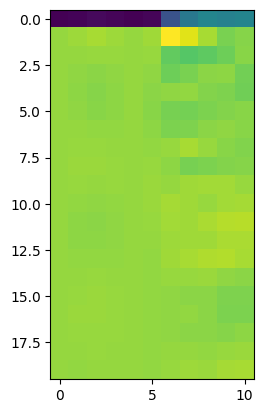

In [48]:
plt.imshow(X_train[100, :, :, 0])
print(y_train[100])

In [49]:
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [52]:
X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len)

# model = Sequential()
# model.add(Flatten(input_shape=(config.buckets, config.max_len)))
# model.add(Dense(num_classes, activation='softmax'))
# model.compile(loss="categorical_crossentropy",
#                   optimizer="adam",
#                   metrics=['accuracy'])
num_classes = 14  # Set the correct number of classes

model = Sequential()
model.add(Flatten(input_shape=(config.buckets, config.max_len)))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with num_classes units
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])


In [53]:
wandb.init()
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

Epoch 1/50
  1/100 [..............................] - ETA: 2:00 - loss: 286.7432 - accuracy: 0.0312

 92/100 [==========================>...] - ETA: 0s - loss: 74.8039 - accuracy: 0.0690

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 3s 16ms/step - loss: 71.2617 - accuracy: 0.0684 - val_loss: 31.0135 - val_accuracy: 0.0712
Epoch 2/50
 92/100 [==========================>...] - ETA: 0s - loss: 26.3141 - accuracy: 0.0778

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 11ms/step - loss: 26.2209 - accuracy: 0.0769 - val_loss: 23.2038 - val_accuracy: 0.0651
Epoch 3/50
 82/100 [=======================>......] - ETA: 0s - loss: 20.9781 - accuracy: 0.0728

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 20.7058 - accuracy: 0.0722 - val_loss: 20.6460 - val_accuracy: 0.0581
Epoch 4/50
 91/100 [==========================>...] - ETA: 0s - loss: 17.7181 - accuracy: 0.0690

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 10ms/step - loss: 17.5814 - accuracy: 0.0678 - val_loss: 18.0022 - val_accuracy: 0.0670
Epoch 5/50
 83/100 [=======================>......] - ETA: 0s - loss: 15.4873 - accuracy: 0.0734

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 10ms/step - loss: 15.5424 - accuracy: 0.0728 - val_loss: 16.3595 - val_accuracy: 0.0623
Epoch 6/50
 97/100 [============================>.] - ETA: 0s - loss: 13.6704 - accuracy: 0.0780

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 14ms/step - loss: 13.6465 - accuracy: 0.0769 - val_loss: 14.6130 - val_accuracy: 0.0628
Epoch 7/50
 95/100 [===========================>..] - ETA: 0s - loss: 12.4173 - accuracy: 0.0796

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 14ms/step - loss: 12.4609 - accuracy: 0.0791 - val_loss: 14.1113 - val_accuracy: 0.0553
Epoch 8/50
 95/100 [===========================>..] - ETA: 0s - loss: 11.9287 - accuracy: 0.0737

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 11ms/step - loss: 11.9153 - accuracy: 0.0744 - val_loss: 13.0997 - val_accuracy: 0.0492
Epoch 9/50
 81/100 [=======================>......] - ETA: 0s - loss: 10.7810 - accuracy: 0.0772

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 10.7328 - accuracy: 0.0778 - val_loss: 12.8978 - val_accuracy: 0.0572
Epoch 10/50
 84/100 [========================>.....] - ETA: 0s - loss: 10.1393 - accuracy: 0.0755

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 10.2664 - accuracy: 0.0750 - val_loss: 11.9746 - val_accuracy: 0.0572
Epoch 11/50
 92/100 [==========================>...] - ETA: 0s - loss: 9.4696 - accuracy: 0.0730

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 9.4682 - accuracy: 0.0741 - val_loss: 11.5031 - val_accuracy: 0.0558
Epoch 12/50
 81/100 [=======================>......] - ETA: 0s - loss: 9.4227 - accuracy: 0.0745

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 9.3863 - accuracy: 0.0725 - val_loss: 11.1116 - val_accuracy: 0.0515
Epoch 13/50
 87/100 [=========================>....] - ETA: 0s - loss: 8.9504 - accuracy: 0.0740

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 8.9446 - accuracy: 0.0744 - val_loss: 11.0621 - val_accuracy: 0.0445
Epoch 14/50
100/100 [==============================] - ETA: 0s - loss: 8.7116 - accuracy: 0.0731

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 8.7116 - accuracy: 0.0731 - val_loss: 10.2737 - val_accuracy: 0.0492
Epoch 15/50
 80/100 [=======================>......] - ETA: 0s - loss: 8.1502 - accuracy: 0.0852

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 8.0947 - accuracy: 0.0878 - val_loss: 10.1088 - val_accuracy: 0.0520
Epoch 16/50
 99/100 [============================>.] - ETA: 0s - loss: 8.0624 - accuracy: 0.0818

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 8.0412 - accuracy: 0.0816 - val_loss: 10.5562 - val_accuracy: 0.0581
Epoch 17/50
 90/100 [==========================>...] - ETA: 0s - loss: 8.0200 - accuracy: 0.0771

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 8.0062 - accuracy: 0.0781 - val_loss: 10.1498 - val_accuracy: 0.0515
Epoch 18/50
 83/100 [=======================>......] - ETA: 0s - loss: 7.6754 - accuracy: 0.0768

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 7.6404 - accuracy: 0.0734 - val_loss: 10.1351 - val_accuracy: 0.0459
Epoch 19/50
 91/100 [==========================>...] - ETA: 0s - loss: 7.4292 - accuracy: 0.0656

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 7.3799 - accuracy: 0.0644 - val_loss: 8.9181 - val_accuracy: 0.0398
Epoch 20/50
 80/100 [=======================>......] - ETA: 0s - loss: 6.9722 - accuracy: 0.0797

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 7.0845 - accuracy: 0.0775 - val_loss: 9.5992 - val_accuracy: 0.0431
Epoch 21/50
 98/100 [============================>.] - ETA: 0s - loss: 6.8906 - accuracy: 0.0788

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 6.8913 - accuracy: 0.0787 - val_loss: 9.8647 - val_accuracy: 0.0445
Epoch 22/50
 93/100 [==========================>...] - ETA: 0s - loss: 7.2366 - accuracy: 0.0743

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 7.2484 - accuracy: 0.0737 - val_loss: 9.1791 - val_accuracy: 0.0506
Epoch 23/50
 86/100 [========================>.....] - ETA: 0s - loss: 6.7582 - accuracy: 0.0759

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 14ms/step - loss: 6.7303 - accuracy: 0.0747 - val_loss: 8.5068 - val_accuracy: 0.0464
Epoch 24/50
 89/100 [=========================>....] - ETA: 0s - loss: 6.8089 - accuracy: 0.0811

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 1s 7ms/step - loss: 6.8711 - accuracy: 0.0775 - val_loss: 8.8678 - val_accuracy: 0.0431
Epoch 25/50
 93/100 [==========================>...] - ETA: 0s - loss: 6.3699 - accuracy: 0.0827

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 1s 7ms/step - loss: 6.4491 - accuracy: 0.0806 - val_loss: 9.0631 - val_accuracy: 0.0384
Epoch 26/50
 86/100 [========================>.....] - ETA: 0s - loss: 6.3396 - accuracy: 0.0887

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 1s 7ms/step - loss: 6.3462 - accuracy: 0.0887 - val_loss: 8.9187 - val_accuracy: 0.0384
Epoch 27/50
 74/100 [=====================>........] - ETA: 0s - loss: 6.3021 - accuracy: 0.0823

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 6.4371 - accuracy: 0.0828 - val_loss: 8.4499 - val_accuracy: 0.0417
Epoch 28/50
 87/100 [=========================>....] - ETA: 0s - loss: 6.4838 - accuracy: 0.0733

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 6.4636 - accuracy: 0.0753 - val_loss: 8.6675 - val_accuracy: 0.0459
Epoch 29/50
 80/100 [=======================>......] - ETA: 0s - loss: 6.0128 - accuracy: 0.0703

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 6.0869 - accuracy: 0.0706 - val_loss: 8.4430 - val_accuracy: 0.0417
Epoch 30/50
 81/100 [=======================>......] - ETA: 0s - loss: 6.3519 - accuracy: 0.0806

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 6.3268 - accuracy: 0.0759 - val_loss: 9.0416 - val_accuracy: 0.0403
Epoch 31/50
 77/100 [======================>.......] - ETA: 0s - loss: 5.9259 - accuracy: 0.0816

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 2s 21ms/step - loss: 5.9187 - accuracy: 0.0828 - val_loss: 8.2025 - val_accuracy: 0.0389
Epoch 32/50
 91/100 [==========================>...] - ETA: 0s - loss: 5.9059 - accuracy: 0.0749

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 12ms/step - loss: 5.8906 - accuracy: 0.0778 - val_loss: 7.7303 - val_accuracy: 0.0403
Epoch 33/50
 92/100 [==========================>...] - ETA: 0s - loss: 5.5745 - accuracy: 0.0785

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 5ms/step - loss: 5.5919 - accuracy: 0.0797 - val_loss: 8.0051 - val_accuracy: 0.0412
Epoch 34/50
 79/100 [======================>.......] - ETA: 0s - loss: 5.5727 - accuracy: 0.0827

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 5.6651 - accuracy: 0.0803 - val_loss: 7.7720 - val_accuracy: 0.0394
Epoch 35/50
 82/100 [=======================>......] - ETA: 0s - loss: 5.4900 - accuracy: 0.0888

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 5.5046 - accuracy: 0.0862 - val_loss: 7.8324 - val_accuracy: 0.0422
Epoch 36/50
 91/100 [==========================>...] - ETA: 0s - loss: 5.7008 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 10ms/step - loss: 5.6837 - accuracy: 0.0753 - val_loss: 7.3868 - val_accuracy: 0.0412
Epoch 37/50
 98/100 [============================>.] - ETA: 0s - loss: 5.4538 - accuracy: 0.0743

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 5.4780 - accuracy: 0.0734 - val_loss: 7.9444 - val_accuracy: 0.0426
Epoch 38/50
 99/100 [============================>.] - ETA: 0s - loss: 5.5378 - accuracy: 0.0821

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 10ms/step - loss: 5.5362 - accuracy: 0.0828 - val_loss: 7.3455 - val_accuracy: 0.0384
Epoch 39/50
 97/100 [============================>.] - ETA: 0s - loss: 5.3235 - accuracy: 0.0796

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 5.3066 - accuracy: 0.0794 - val_loss: 7.4288 - val_accuracy: 0.0328
Epoch 40/50
 89/100 [=========================>....] - ETA: 0s - loss: 5.6073 - accuracy: 0.0790

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 1s 7ms/step - loss: 5.5974 - accuracy: 0.0806 - val_loss: 7.9231 - val_accuracy: 0.0351
Epoch 41/50
 93/100 [==========================>...] - ETA: 0s - loss: 5.4987 - accuracy: 0.0766

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 1s 5ms/step - loss: 5.4902 - accuracy: 0.0763 - val_loss: 8.5670 - val_accuracy: 0.0469
Epoch 42/50
 99/100 [============================>.] - ETA: 0s - loss: 5.2691 - accuracy: 0.0786

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 1s 5ms/step - loss: 5.2609 - accuracy: 0.0781 - val_loss: 7.6617 - val_accuracy: 0.0483
Epoch 43/50
 94/100 [===========================>..] - ETA: 0s - loss: 5.1702 - accuracy: 0.0775

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 14ms/step - loss: 5.1878 - accuracy: 0.0769 - val_loss: 7.2055 - val_accuracy: 0.0389
Epoch 44/50
 90/100 [==========================>...] - ETA: 0s - loss: 5.2247 - accuracy: 0.0785

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 1s 6ms/step - loss: 5.2455 - accuracy: 0.0750 - val_loss: 7.2875 - val_accuracy: 0.0384
Epoch 45/50
 95/100 [===========================>..] - ETA: 0s - loss: 5.3505 - accuracy: 0.0911

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 5ms/step - loss: 5.3549 - accuracy: 0.0903 - val_loss: 8.1334 - val_accuracy: 0.0328
Epoch 46/50
 85/100 [========================>.....] - ETA: 0s - loss: 5.3179 - accuracy: 0.0842

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 5.3211 - accuracy: 0.0831 - val_loss: 7.7718 - val_accuracy: 0.0347
Epoch 47/50
 82/100 [=======================>......] - ETA: 0s - loss: 5.3152 - accuracy: 0.0785

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 4ms/step - loss: 5.2876 - accuracy: 0.0772 - val_loss: 7.2407 - val_accuracy: 0.0403
Epoch 48/50
 99/100 [============================>.] - ETA: 0s - loss: 5.0271 - accuracy: 0.0789

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 3ms/step - loss: 5.0265 - accuracy: 0.0787 - val_loss: 7.4980 - val_accuracy: 0.0370
Epoch 49/50
 77/100 [======================>.......] - ETA: 0s - loss: 5.0540 - accuracy: 0.0832

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 0s 3ms/step - loss: 5.0665 - accuracy: 0.0812 - val_loss: 7.3341 - val_accuracy: 0.0459
Epoch 50/50
 82/100 [=======================>......] - ETA: 0s - loss: 5.1270 - accuracy: 0.0785

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215553-anwzjnhr/files/model-best)... Done. 0.0s


100/100 [==============================] - 1s 9ms/step - loss: 5.1428 - accuracy: 0.0772 - val_loss: 6.8250 - val_accuracy: 0.0384


In [56]:
from keras.layers import Reshape

# Build model
model = Sequential()
model.add(Reshape((config.buckets * config.max_len, channels), input_shape=(config.buckets, config.max_len, channels)))
model.add(LSTM(16, activation="sigmoid"))
model.add(Dense(1, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))


In [57]:
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [58]:
wandb.init()
model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="image", labels=labels)])

accuracy,▂▅▃▂▅▅▄▅▄▃▄▄▆▅▄▁▅▄▄▅█▆▄▃▆▅▅▆▄▄▆▅▄▅▅▄▆▅▅▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▇▆▇▆▅▄▅▅▄▃▄▆▄▃▂▃▄▃▃▂▃▃▃▂▂▃▂▃▃▂▁▄▄▂▂▁▂▂▂
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
accuracy,0.07719
best_epoch,49
best_val_loss,6.825
epoch,49
loss,5.14281
val_accuracy,0.03843


Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 2.6507 - accuracy: 0.0764

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215919-cx5ajq90/files/model-best)... Done. 0.0s


100/100 [==============================] - 12s 104ms/step - loss: 2.6504 - accuracy: 0.0769 - val_loss: 2.6479 - val_accuracy: 0.0633
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 2.6413 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215919-cx5ajq90/files/model-best)... Done. 0.0s


100/100 [==============================] - 10s 103ms/step - loss: 2.6413 - accuracy: 0.0769 - val_loss: 2.6435 - val_accuracy: 0.0633
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 2.6393 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215919-cx5ajq90/files/model-best)... Done. 0.0s


100/100 [==============================] - 8s 84ms/step - loss: 2.6393 - accuracy: 0.0769 - val_loss: 2.6425 - val_accuracy: 0.0633
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 2.6388 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240323_215919-cx5ajq90/files/model-best)... Done. 0.0s


100/100 [==============================] - 10s 102ms/step - loss: 2.6388 - accuracy: 0.0769 - val_loss: 2.6423 - val_accuracy: 0.0633
Epoch 5/50
100/100 [==============================] - ETA: 0s - loss: 2.6386 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 80ms/step - loss: 2.6386 - accuracy: 0.0769 - val_loss: 2.6425 - val_accuracy: 0.0633
Epoch 6/50
100/100 [==============================] - ETA: 0s - loss: 2.6384 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 63ms/step - loss: 2.6384 - accuracy: 0.0769 - val_loss: 2.6425 - val_accuracy: 0.0633
Epoch 7/50
100/100 [==============================] - ETA: 0s - loss: 2.6382 - accuracy: 0.0794

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 84ms/step - loss: 2.6382 - accuracy: 0.0794 - val_loss: 2.6430 - val_accuracy: 0.0623
Epoch 8/50
100/100 [==============================] - ETA: 0s - loss: 2.6383 - accuracy: 0.0763

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 63ms/step - loss: 2.6383 - accuracy: 0.0763 - val_loss: 2.6431 - val_accuracy: 0.0614
Epoch 9/50
100/100 [==============================] - ETA: 0s - loss: 2.6382 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 9s 88ms/step - loss: 2.6382 - accuracy: 0.0769 - val_loss: 2.6435 - val_accuracy: 0.0548
Epoch 10/50
100/100 [==============================] - ETA: 0s - loss: 2.6381 - accuracy: 0.0750

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 64ms/step - loss: 2.6381 - accuracy: 0.0750 - val_loss: 2.6437 - val_accuracy: 0.0581
Epoch 11/50
100/100 [==============================] - ETA: 0s - loss: 2.6381 - accuracy: 0.0756

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 81ms/step - loss: 2.6381 - accuracy: 0.0756 - val_loss: 2.6438 - val_accuracy: 0.0595
Epoch 12/50
100/100 [==============================] - ETA: 0s - loss: 2.6381 - accuracy: 0.0791

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 62ms/step - loss: 2.6381 - accuracy: 0.0791 - val_loss: 2.6437 - val_accuracy: 0.0586
Epoch 13/50
100/100 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.0750

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 10s 97ms/step - loss: 2.6380 - accuracy: 0.0750 - val_loss: 2.6441 - val_accuracy: 0.0595
Epoch 14/50
100/100 [==============================] - ETA: 0s - loss: 2.6381 - accuracy: 0.0747

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 64ms/step - loss: 2.6381 - accuracy: 0.0747 - val_loss: 2.6444 - val_accuracy: 0.0572
Epoch 15/50
100/100 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.0756

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 81ms/step - loss: 2.6380 - accuracy: 0.0756 - val_loss: 2.6445 - val_accuracy: 0.0614
Epoch 16/50
 99/100 [============================>.] - ETA: 0s - loss: 2.6379 - accuracy: 0.0773

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 64ms/step - loss: 2.6380 - accuracy: 0.0769 - val_loss: 2.6446 - val_accuracy: 0.0619
Epoch 17/50
100/100 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.0781

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 82ms/step - loss: 2.6380 - accuracy: 0.0781 - val_loss: 2.6447 - val_accuracy: 0.0623
Epoch 18/50
100/100 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.0794

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 7s 66ms/step - loss: 2.6380 - accuracy: 0.0794 - val_loss: 2.6444 - val_accuracy: 0.0633
Epoch 19/50
100/100 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 83ms/step - loss: 2.6380 - accuracy: 0.0769 - val_loss: 2.6447 - val_accuracy: 0.0614
Epoch 20/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0787

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 62ms/step - loss: 2.6379 - accuracy: 0.0787 - val_loss: 2.6449 - val_accuracy: 0.0637
Epoch 21/50
 99/100 [============================>.] - ETA: 0s - loss: 2.6382 - accuracy: 0.0770

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 82ms/step - loss: 2.6381 - accuracy: 0.0778 - val_loss: 2.6449 - val_accuracy: 0.0628
Epoch 22/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0763

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 62ms/step - loss: 2.6379 - accuracy: 0.0763 - val_loss: 2.6451 - val_accuracy: 0.0628
Epoch 23/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0744

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 80ms/step - loss: 2.6379 - accuracy: 0.0744 - val_loss: 2.6448 - val_accuracy: 0.0633
Epoch 24/50
100/100 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.0722

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 61ms/step - loss: 2.6380 - accuracy: 0.0722 - val_loss: 2.6447 - val_accuracy: 0.0600
Epoch 25/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0756

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 82ms/step - loss: 2.6379 - accuracy: 0.0756 - val_loss: 2.6450 - val_accuracy: 0.0637
Epoch 26/50
 99/100 [============================>.] - ETA: 0s - loss: 2.6380 - accuracy: 0.0770

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 62ms/step - loss: 2.6380 - accuracy: 0.0766 - val_loss: 2.6449 - val_accuracy: 0.0623
Epoch 27/50
100/100 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.0759

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 84ms/step - loss: 2.6380 - accuracy: 0.0759 - val_loss: 2.6451 - val_accuracy: 0.0633
Epoch 28/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0787

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 62ms/step - loss: 2.6379 - accuracy: 0.0787 - val_loss: 2.6454 - val_accuracy: 0.0623
Epoch 29/50
100/100 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.0756

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 80ms/step - loss: 2.6380 - accuracy: 0.0756 - val_loss: 2.6451 - val_accuracy: 0.0647
Epoch 30/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0781

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 65ms/step - loss: 2.6379 - accuracy: 0.0781 - val_loss: 2.6449 - val_accuracy: 0.0637
Epoch 31/50
100/100 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 9s 94ms/step - loss: 2.6378 - accuracy: 0.0769 - val_loss: 2.6453 - val_accuracy: 0.0619
Epoch 32/50
100/100 [==============================] - ETA: 0s - loss: 2.6380 - accuracy: 0.0741

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 63ms/step - loss: 2.6380 - accuracy: 0.0741 - val_loss: 2.6449 - val_accuracy: 0.0614
Epoch 33/50
100/100 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.0734

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 81ms/step - loss: 2.6378 - accuracy: 0.0734 - val_loss: 2.6453 - val_accuracy: 0.0623
Epoch 34/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0747

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 63ms/step - loss: 2.6379 - accuracy: 0.0747 - val_loss: 2.6450 - val_accuracy: 0.0581
Epoch 35/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0759

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 83ms/step - loss: 2.6379 - accuracy: 0.0759 - val_loss: 2.6451 - val_accuracy: 0.0604
Epoch 36/50
 99/100 [============================>.] - ETA: 0s - loss: 2.6378 - accuracy: 0.0745

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 64ms/step - loss: 2.6378 - accuracy: 0.0747 - val_loss: 2.6451 - val_accuracy: 0.0623
Epoch 37/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0787

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 83ms/step - loss: 2.6379 - accuracy: 0.0787 - val_loss: 2.6453 - val_accuracy: 0.0590
Epoch 38/50
 99/100 [============================>.] - ETA: 0s - loss: 2.6377 - accuracy: 0.0770

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 62ms/step - loss: 2.6378 - accuracy: 0.0763 - val_loss: 2.6453 - val_accuracy: 0.0633
Epoch 39/50
100/100 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.0763

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 81ms/step - loss: 2.6378 - accuracy: 0.0763 - val_loss: 2.6452 - val_accuracy: 0.0604
Epoch 40/50
100/100 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.0766

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 64ms/step - loss: 2.6378 - accuracy: 0.0766 - val_loss: 2.6455 - val_accuracy: 0.0609
Epoch 41/50
100/100 [==============================] - ETA: 0s - loss: 2.6379 - accuracy: 0.0784

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 79ms/step - loss: 2.6379 - accuracy: 0.0784 - val_loss: 2.6452 - val_accuracy: 0.0604
Epoch 42/50
100/100 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 63ms/step - loss: 2.6378 - accuracy: 0.0769 - val_loss: 2.6452 - val_accuracy: 0.0600
Epoch 43/50
100/100 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 80ms/step - loss: 2.6378 - accuracy: 0.0769 - val_loss: 2.6453 - val_accuracy: 0.0590
Epoch 44/50
100/100 [==============================] - ETA: 0s - loss: 2.6377 - accuracy: 0.0772

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 63ms/step - loss: 2.6377 - accuracy: 0.0772 - val_loss: 2.6455 - val_accuracy: 0.0614
Epoch 45/50
100/100 [==============================] - ETA: 0s - loss: 2.6377 - accuracy: 0.0769

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 76ms/step - loss: 2.6377 - accuracy: 0.0769 - val_loss: 2.6456 - val_accuracy: 0.0604
Epoch 46/50
100/100 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.0781

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 64ms/step - loss: 2.6378 - accuracy: 0.0781 - val_loss: 2.6455 - val_accuracy: 0.0600
Epoch 47/50
100/100 [==============================] - ETA: 0s - loss: 2.6377 - accuracy: 0.0772

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 9s 90ms/step - loss: 2.6377 - accuracy: 0.0772 - val_loss: 2.6454 - val_accuracy: 0.0600
Epoch 48/50
100/100 [==============================] - ETA: 0s - loss: 2.6377 - accuracy: 0.0728

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 64ms/step - loss: 2.6377 - accuracy: 0.0728 - val_loss: 2.6454 - val_accuracy: 0.0604
Epoch 49/50
100/100 [==============================] - ETA: 0s - loss: 2.6377 - accuracy: 0.0784

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 8s 82ms/step - loss: 2.6377 - accuracy: 0.0784 - val_loss: 2.6456 - val_accuracy: 0.0604
Epoch 50/50
100/100 [==============================] - ETA: 0s - loss: 2.6378 - accuracy: 0.0791

wandb: WARNING No validation_data set, pass a generator to the callback.


100/100 [==============================] - 6s 63ms/step - loss: 2.6378 - accuracy: 0.0791 - val_loss: 2.6457 - val_accuracy: 0.0595
